In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import cv2
import scanorama
from sklearn.model_selection import train_test_split

In [2]:
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

In [3]:
# Check pytorch
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))


True
0
2
NVIDIA GeForce RTX 2080 Ti


In [4]:
import torch_geometric.utils

spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'
process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'

# Read data

In [6]:
# Read all spadata info
datasets = []
paths = []
path_rois = []

# Loop through data
for (dirpath, dirnames, filenames) in os.walk(spatial_omics_folder):
    for name in tqdm(sorted(filenames)):
        if 'hdf5' not in name:
            continue
         
        # read adata
        data_name = name.split('.')[0]
        path = os.path.join(dirpath, name)
        if 'roi' not in name:
            datasets.append(data_name)
            paths.append(os.path.join(dirpath, name))
            path_rois.append(os.path.join(dirpath, data_name+'_roi.hdf5'))
            
df = pd.DataFrame({'Dataset': datasets, 'Path': paths, 'Path_ROI': path_rois})
df = df[df.Dataset!= '05']

  0%|          | 0/34 [00:00<?, ?it/s]

In [7]:
adata_dir = (Path().cwd().parents[0]).absolute() / 'data'/ 'processed'
adatas = []
datasets = []

# Loop through data
for (dirpath, dirnames, filenames) in os.walk(adata_dir):
    for name in tqdm(sorted(filenames)):
        if 'h5ad' not in name:
            continue
        if name == '05.h5ad':
            continue
        
        # read adata
        data_name = name.split('.')[0]
        print(f'Processing Data {data_name}')   
        path = os.path.join(dirpath, name)
        
        adata = sc.read_h5ad(path)
        adata.obs['Data'] = data_name
        
        if 'Dataset' in adata.obs:
            for d in adata.obs.Dataset.unique():
                a = adata[adata.obs.Dataset == d]
                adatas.append(a)
                datasets.append(data_name+f'_{d}')
        else:
            adatas.append(adata)
            datasets.append(data_name)

  0%|          | 0/17 [00:00<?, ?it/s]

Processing Data 01
Processing Data 03
Processing Data 05_v1
Processing Data 07_A11
Processing Data 07_A18
Processing Data 07_A21
Processing Data 07_A22
Processing Data 07_A6
Processing Data 07_A8
Processing Data 07_T18
Processing Data 07_T22
Processing Data 07_T3
Processing Data 07_T5
Processing Data 07_T6
Processing Data 07_T8
Processing Data 08


# Create all data

In [7]:
keep_names = ['cd11c', 'cd20', 'cd21', 'hladr', 'cd68', 'ki67', 'cd19']
final_names = ['CD21', 'CD20', 'CD21', 'CD68', 'CD68', 'Ki67', 'CD20']
mapping = dict(zip(keep_names, final_names))

adatas_filtered = []
for adata in adatas:
    lower_var_names = adata.var_names.map(lambda x: x.split('_')[0]).str.lower()
    indices = lower_var_names.isin(keep_names)
    adata_s = adata[:, indices]
    if len(adata_s.var_names) > 4:
        indices = lower_var_names.isin(keep_names[:-1])
        adata_s = adata[:, indices]
    columns = adata_s.var_names.map(lambda x: x.split('_')[0]).str.lower()
    columns = columns.map(mapping)
    adata_s.var_names = columns
    sc.pp.scale(adata_s, max_value=5)
    adatas_filtered.append(adata_s)
    
adata_combined = ad.concat(adatas_filtered, axis=0)

C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
sc.pp.combat(adata_combined, key='Data')

... storing 'Data' as categorical


## Create torch dataset Follicle only

In [9]:
adata_combined_foll = adata_combined[adata_combined.obs.Foll > 0]
adata_combined_foll.obs.Data.unique()

['01', '03', '05_v1', '07_A11', '07_A18', ..., '07_T3', '07_T5', '07_T6', '07_T8', '08']
Length: 16
Categories (16, object): ['01', '03', '05_v1', '07_A6', ..., '07_T8', '07_T18', '07_T22', '08']

In [ ]:
# Create csv for all graph info
save_path = process_path / 'All' 
pt_path = save_path / 'pt'
pt_path.mkdir(parents=True, exist_ok=True)

# Define tissue types 
# 0: Tonsil, 1: Adenoid
tissue_types = [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
assert len(tissue_types) == len(df)

# Create csv for all graph info
csv_path = save_path / 'info.csv'

test_size = 0.35

data_names = []
foll_ids = []
paths = []
spadata_paths = []
spadata_roi_paths = []

for i, row in enumerate(df.itertuples()):
    dataset = row.Dataset
    
    # Read spadata
    path = row.Path
    spadata = SpatialOmics.from_h5py(path)
    adata_dataset = adata_combined_foll[adata_combined_foll.obs.Data == dataset]
    
    # Loop through foll
    for foll in spadata.spl.Foll:
        # Filter out foll with less than 50 cells
        l = len(spadata.X[str(foll)])
        if l < 50:
            continue 
            
        # Generate torch data
        G = spadata.G[str(foll)]['contact']
        pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
        classes = (spadata.obs[str(foll)]['GC']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        adata_subset = adata_dataset[adata_dataset.obs.Foll == foll]
        df_int = pd.DataFrame(adata_subset.X, index=adata_subset.obs.Cell)
        X = df_int.loc[np.array(G.nodes)].values
        
        data = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
        data.x = torch.tensor(X).float()
        data.pos = torch.tensor(pos).float()
        data.node_types = torch.tensor(classes)
        data.label = torch.tensor(tissue_types[i])
        
        # Generate train and test mask at node level
        G = spadata.G[str(foll)]['contact']
        X_train, X_test, _, _ = train_test_split(pd.Series(list(G.nodes())), 
                                                pd.Series(spadata.obs[str(foll)]['GC']),
                                                test_size=test_size, 
                                                random_state=42)

        n_nodes = G.number_of_nodes()

        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        
        # Save data and info
        path = save_path / 'pt' / f'{dataset}_{foll}.pt'
        torch.save(data, path)
        data_names.append(dataset)
        foll_ids.append(foll)
        paths.append(path)
        spadata_paths.append(row.Path)
        spadata_roi_paths.append(row.Path_ROI)
    
df_info = pd.DataFrame({'Dataset': data_names, 'Foll': foll_ids, 'Path': paths,
                       'Path_spadata': spadata_paths, 'Path_spadata_roi':spadata_roi_paths})
df_info.to_csv(csv_path)

In [ ]:
df_info['fileName'] = df_info['Path'].map(lambda x: str(x).split('\\')[-1])

In [ ]:
df_info.to_csv(csv_path)

## Create torch dataset Follicle ROI

In [ ]:
# Create csv for all graph info
save_path = process_path / 'All_roi' 
pt_path = save_path / 'pt'
pt_path.mkdir(parents=True, exist_ok=True)

# Define tissue types 
# 0: Tonsil, 1: Adenoid
tissue_types = [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
assert len(tissue_types) == len(df)

# Create csv for all graph info
csv_path = save_path / 'info.csv'

test_size = 0.35

data_names = []
foll_ids = []
paths = []
spadata_paths = []
spadata_roi_paths = []

for i, row in enumerate(df.itertuples()):
    dataset = row.Dataset
    
    # Read spadata
    path = row.Path_ROI
    spadata = SpatialOmics.from_h5py(path)
    adata_dataset = adata_combined[adata_combined.obs.Data == dataset]
    df_int = pd.DataFrame(adata_dataset.X, index=adata_dataset.obs.Cell)

    # Loop through foll
    for foll in spadata.spl.Foll:
        # Filter out foll with less than 50 cells
        l = len(spadata.X[str(foll)])
        if l < 50:
            continue 
    
        # Generate torch data
        G = spadata.G[str(foll)]['contact']
        pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
        gc_onehot = (spadata.obs[str(foll)]['GC']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        foll_onehot = (spadata.obs[str(foll)]['Foll']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        classes = gc_onehot + foll_onehot
        X = df_int.loc[np.array(G.nodes)].values
        
        data = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
        data.x = torch.tensor(X).float()
        data.pos = torch.tensor(pos).float()
        data.node_types = torch.tensor(classes)
        data.label = torch.tensor(tissue_types[i])
        
        # Generate train and test mask at node level
        G = spadata.G[str(foll)]['contact']
        X_train, X_test, _, _ = train_test_split(pd.Series(list(G.nodes())), 
                                                pd.Series(spadata.obs[str(foll)]['GC']),
                                                test_size=test_size, 
                                                random_state=42)

        n_nodes = G.number_of_nodes()

        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        
        # Save data and info
        path = pt_path / f'{dataset}_{foll}.pt'
        torch.save(data, path)
        data_names.append(dataset)
        foll_ids.append(foll)
        paths.append(path)
        spadata_paths.append(row.Path)
        spadata_roi_paths.append(row.Path_ROI)
    
df_info = pd.DataFrame({'Dataset': data_names, 'Foll': foll_ids, 'Path': paths,
                       'Path_spadata': spadata_paths, 'Path_spadata_roi':spadata_roi_paths})
df_info.to_csv(csv_path)

# NIH data

In [8]:
# Get MIH data
nih_adatas = []
for i, adata in enumerate(adatas):
    if '07' in datasets[i]:
        print(datasets[i])
        nih_adatas.append(adata)
    
# Scale adata and combine
adatas_filtered = []
for adata in nih_adatas:
    sc.pp.scale(adata, max_value=5)
    adatas_filtered.append(adata)
    
adata_combined = ad.concat(nih_adatas, axis=0)    
adata_combined = adata_combined[:,['CD21', 'CD20', 'CD68', 'Ki67', 'CD138']]
# sc.pp.combat(adata_combined, key='Data')

07_A11_A11
07_A18_A18
07_A21_A21
07_A22_A22
07_A6_A6
07_A8_A8
07_T18_T18
07_T22_T22
07_T3_T3
07_T5_T5
07_T6_T6
07_T8_T8


C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Re

In [9]:
df_nih = df[df.Dataset.str.contains('07')]

In [10]:
df_nih

,Dataset,Path,Path_ROI
4,07_A11,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
5,07_A18,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
6,07_A21,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
7,07_A22,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
8,07_A6,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
9,07_A8,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
10,07_T18,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
11,07_T22,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
12,07_T3,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...
13,07_T5,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...,Y:\coskun-lab\Thomas\11_snowflakes\data\spatia...


In [11]:
covid = [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [12]:
adata_combined 

View of AnnData object with n_obs × n_vars = 4728342 × 5
    obs: 'ROI', 'Cell', 'Cell_ROI', 'Dataset', 'Data', 'Foll', 'GC'
    obsm: 'spatial'

In [25]:
adata_subset = adata_combined[::10]

In [26]:
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)

C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


... storing 'Dataset' as categorical
... storing 'Data' as categorical
C:\Users\thu71\Anaconda3\envs\snowflake\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


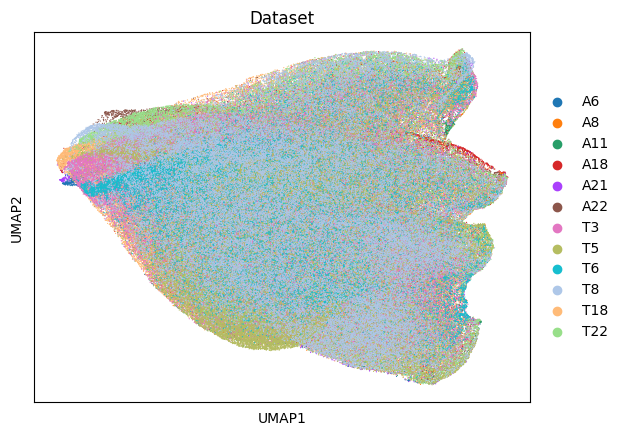

In [27]:
# Plot umap to quickly verify that we don't have clear seperation of datasets
sc.pl.umap(adata_subset, color=['Dataset'], size=3)

In [14]:
adata_combined.var_names

Index(['CD21', 'CD20', 'CD68', 'Ki67', 'CD138'], dtype='object')

## Create Foll region

In [33]:
# Create csv for all graph info
save_path = process_path / 'NIH' 
pt_path = save_path / 'pt'
pt_path.mkdir(parents=True, exist_ok=True)

# Define tissue types 
# 0: Tonsil, 1: Adenoid
tissue_types = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
covid = [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
assert len(tissue_types) == len(df_nih)
assert len(covid) == len(df_nih)

# Create csv for all graph info
csv_path = save_path / 'info.csv'

test_size = 0.35

data_names = []
foll_ids = []
paths = []
spadata_paths = []
spadata_roi_paths = []

for i, row in enumerate(df_nih.itertuples()):
    dataset = row.Dataset
    
    # Read spadata
    path = row.Path
    spadata = SpatialOmics.from_h5py(path)
    adata_dataset = adata_combined[adata_combined.obs.Data == dataset]
    
    # Loop through foll
    for foll in spadata.spl.Foll:
        # Filter out foll with less than 50 cells
        l = len(spadata.X[str(foll)])
        if l < 50:
            continue 
            
        # Generate torch data
        G = spadata.G[str(foll)]['contact']
        pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
        classes = (spadata.obs[str(foll)]['GC']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        adata_subset = adata_dataset[adata_dataset.obs.Foll == foll]
        df_int = pd.DataFrame(adata_subset.X, index=adata_subset.obs.Cell)
        X = df_int.loc[np.array(G.nodes)].values
        
        data = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
        data.x = torch.tensor(X).float()
        data.pos = torch.tensor(pos).float()
        data.node_types = torch.tensor(classes)
        data.label = torch.tensor(tissue_types[i])
        data.covid = torch.tensor(covid[i])
        
        # Generate train and test mask at node level
        G = spadata.G[str(foll)]['contact']
        X_train, X_test, _, _ = train_test_split(pd.Series(list(G.nodes())), 
                                                pd.Series(spadata.obs[str(foll)]['GC']),
                                                test_size=test_size, 
                                                random_state=42)

        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        
        # Save data and info
        path = pt_path / f'{dataset}_{foll}.pt'
        torch.save(data, path)
        data_names.append(dataset)
        foll_ids.append(foll)
        paths.append(path)
        spadata_paths.append(row.Path)
        spadata_roi_paths.append(row.Path_ROI)
    
df_info = pd.DataFrame({'Dataset': data_names, 'Foll': foll_ids, 'Path': paths,
                       'Path_spadata': spadata_paths, 'Path_spadata_roi':spadata_roi_paths})
df_info.to_csv(csv_path)

## Create Foll ROI

In [15]:
# Create csv for all graph info
save_path = process_path / 'NIH_roi' 
pt_path = save_path / 'pt'
pt_path.mkdir(parents=True, exist_ok=True)

# Define tissue types 
# 0: Tonsil, 1: Adenoid
tissue_types = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
covid = [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
assert len(tissue_types) == len(df_nih)
assert len(covid) == len(df_nih)

# Create csv for all graph info
csv_path = save_path / 'info.csv'

test_size = 0.35

data_names = []
foll_ids = []
paths = []
spadata_paths = []
spadata_roi_paths = []

for i, row in enumerate(df_nih.itertuples()):
    dataset = row.Dataset
    
    # Read spadata
    path = row.Path_ROI
    spadata = SpatialOmics.from_h5py(path)
    adata_dataset = adata_combined[adata_combined.obs.Data == dataset]
    df_int = pd.DataFrame(adata_dataset.X, index=adata_dataset.obs.Cell)

    # Loop through foll
    for foll in spadata.spl.Foll:
        # Filter out foll with less than 50 cells
        l = len(spadata.X[str(foll)])
        if l < 50:
            continue 
    
        # Generate torch data
        G = spadata.G[str(foll)]['contact']
        pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
        gc_onehot = (spadata.obs[str(foll)]['GC']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        foll_onehot = (spadata.obs[str(foll)]['Foll']>0).loc[np.array(G.nodes())].astype(np.uint8).to_numpy()
        classes = gc_onehot + foll_onehot
        X = df_int.loc[np.array(G.nodes)].values
        
        data = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
        data.x = torch.tensor(X).float()
        data.pos = torch.tensor(pos).float()
        data.node_types = torch.tensor(classes)
        data.label = torch.tensor(tissue_types[i])
        data.covid = torch.tensor(covid[i])
        
        # Generate train and test mask at node level
        G = spadata.G[str(foll)]['contact']
        X_train, X_test, _, _ = train_test_split(pd.Series(list(G.nodes())), 
                                                pd.Series(spadata.obs[str(foll)]['GC']),
                                                test_size=test_size, 
                                                random_state=42)

        n_nodes = G.number_of_nodes()

        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask
        
        # Save data and info
        path = pt_path / f'{dataset}_{foll}.pt'
        torch.save(data, path)
        data_names.append(dataset)
        foll_ids.append(foll)
        paths.append(path)
        spadata_paths.append(row.Path)
        spadata_roi_paths.append(row.Path_ROI)
    
df_info = pd.DataFrame({'Dataset': data_names, 'Foll': foll_ids, 'Path': paths,
                       'Path_spadata': spadata_paths, 'Path_spadata_roi':spadata_roi_paths})
df_info.to_csv(csv_path)

# Data